In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## CUDA available?

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Project 1 Cat & Dog Classification

We want to distinguish between images of cats and dogs. You must train a deep neural network to perform the classification task. To execute this task, you must work in groups of 2 people plus/minus 1. The dataset consists of 3600 images of cats and dogs, 1800 images of each class. The image format is jpeg, with 3 color channels.

## Task 1 - Create the dataloader
Due to the high amount of data, you need to write a dataloader to load the images. You must apply at least one on-the-fly data augmentation. Which type of data augmentaAon is up to you, but you need to justify your choice in your report.

In [85]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
image_path = "data"
walk_through_dir(image_path)

There are 3 directories and 1 images in 'data'.
There are 2 directories and 0 images in 'data\test'.
There are 0 directories and 200 images in 'data\test\cats'.
There are 0 directories and 200 images in 'data\test\dogs'.
There are 2 directories and 0 images in 'data\train'.
There are 0 directories and 1000 images in 'data\train\cats'.
There are 0 directories and 1000 images in 'data\train\dogs'.
There are 2 directories and 0 images in 'data\validation'.
There are 0 directories and 300 images in 'data\validation\cats'.
There are 0 directories and 300 images in 'data\validation\dogs'.


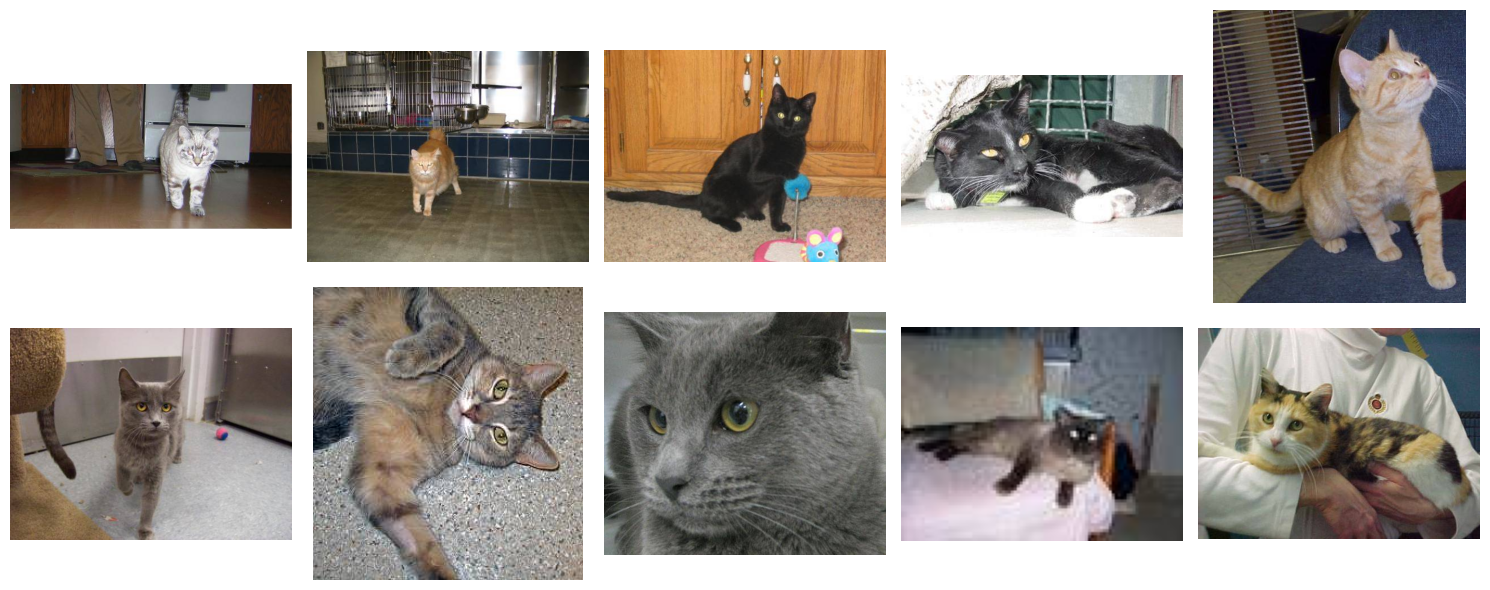

In [86]:
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import random

# Load the dataset without transformations
original_dataset = datasets.ImageFolder("data/train", transform=None)

# Filter for "cats" images only
cat_class_index = original_dataset.class_to_idx['cats']  # Get the index for the 'cats' class
cat_images = [img for img, label in original_dataset if label == cat_class_index]

# Function to display random images in a 2-row grid
def show_random_cat_images(cat_images, num_images=10, images_per_row=5):
    random_cats = random.sample(cat_images, num_images)  # Take a random sample of cat images
    rows = num_images // images_per_row
    fig, axes = plt.subplots(rows, images_per_row, figsize=(15, 6))
    axes = axes.flatten()
    for i, img in enumerate(random_cats):
        img_np = np.array(img)  # Convert PIL image to numpy array for display
        axes[i].imshow(img_np)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display 10 random cat images in a 2-row grid (5 per row)
show_random_cat_images(cat_images, num_images=10, images_per_row=5)

In [87]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_data_loaders(train_dir, val_dir, test_dir, batch_size=32):
    # Basic transformation: resize images to a fixed size and convert to tensor
    basic_transforms = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize all images to 224x224
        transforms.ToTensor()           # Convert to tensor
    ])

    # Load datasets
    train_dataset = datasets.ImageFolder(train_dir, transform=basic_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=basic_transforms)
    test_dataset = datasets.ImageFolder(test_dir, transform=basic_transforms)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

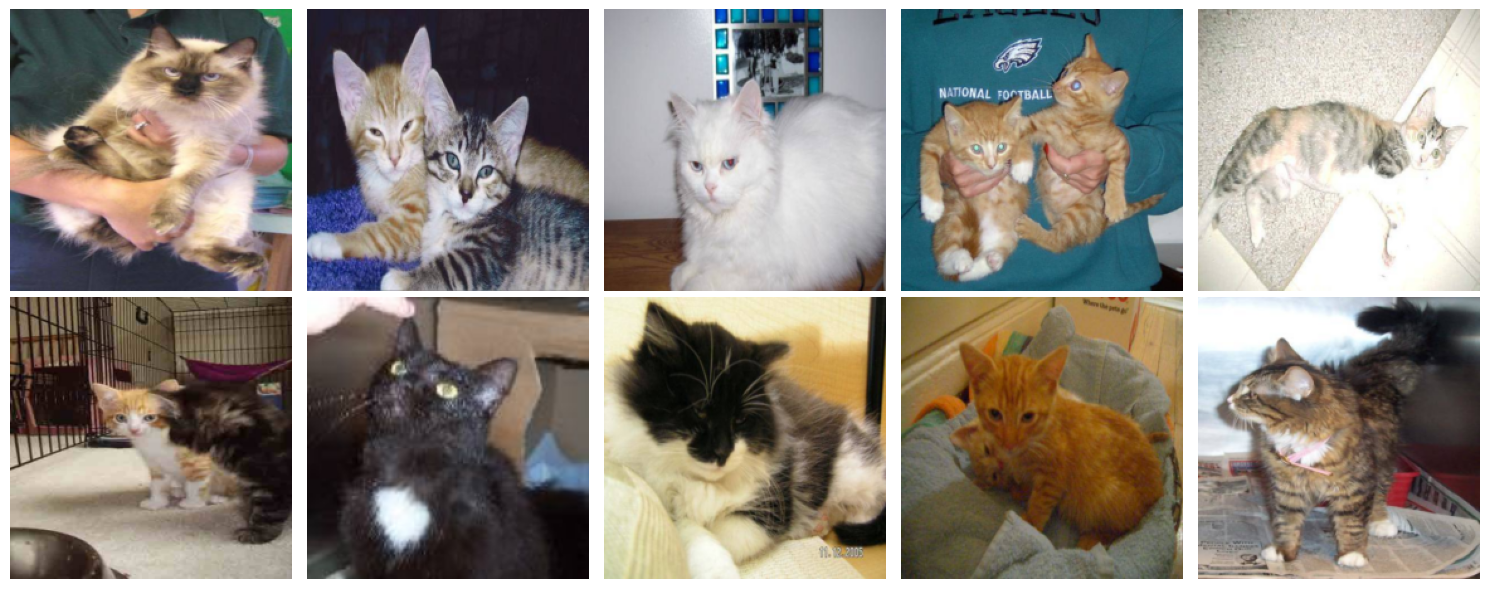

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Function to display images in a grid (5 images per row, without labels)
def show_images(images, images_per_row=5):
    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row  # Calculate rows needed
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes[:num_images]):
        img = np.transpose(images[i].numpy(), (1, 2, 0))  # Convert Tensor to numpy array
        img = np.clip(img, 0, 1)  # Ensure values are within [0, 1] for display
        ax.imshow(img)
        ax.axis('off')  # Remove axis/labels
    
    plt.tight_layout()
    plt.show()

# Fetch a single batch
train_loader, _, _ = get_data_loaders("data/train", "data/validation", "data/test")
class_names = train_loader.dataset.classes  # ['cats', 'dogs']
cat_label = class_names.index('cats')  # Get the index for "cats" class

# Get a batch and filter only cat images
dataiter = iter(train_loader)
images, labels = next(dataiter)
cat_images = [images[i] for i in range(len(labels)) if labels[i].item() == cat_label]

# Take a random sample of 10 cat images
cat_images_sample = torch.stack(random.sample(cat_images, 10))

# Display the random sample of cat images
show_images(cat_images_sample)

## Task 2 - Constructing the network
After successfully crafting the data generators, you need to craft a neural network, and use the dataloader to feed the network. The architecture, complexity and regularizers are all up to you, but you need to justify your choices in the report. You are more than welcome to replicate already known architectures or architectures we made during the course, but you are not allowed to use any pretrained networks. You are also not allowed to use any training data that isn't included on ItsLearning. Carefully consider which hyperparameters to test and strategically try to find the optimal architecture for the task. In the comments, please describe your method for the optimization and your choice of hyperparameters.

In [94]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_data_loaders(train_dir, val_dir, test_dir, batch_size=32):
    # Data augmentation for training set
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),             # resize shortest side to 224 pixels
        transforms.TrivialAugmentWide(),
        transforms.ToTensor()])

    # No augmentation for validation and test set, only resizing and normalizing
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])

    # Load datasets
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

### Constructing a Custom Network

In [95]:
import torch.nn as nn
import torch.nn.functional as F

class CatDogClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 512, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2)) 
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=2))

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x

### Training Function with Hyperparameter Testing

In [96]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_acc = validate_model(model, val_loader, device)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Validation Accuracy: {val_acc}%")

        # Save the model if validation accuracy improved
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

def validate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


### Test Model and Visualize Results

In [97]:
import matplotlib.pyplot as plt

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total}%")

def plot_training_history(train_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.show()

def visualize_sample_predictions(model, data_loader, device):
    model.eval()
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        plt.title(f'Pred: {preds[i].item()}, True: {labels[i].item()}')
        plt.axis('off')
    plt.show()

In [98]:
# Load data
train_loader, val_loader, test_loader = get_data_loaders("data/train", "data/validation", "data/test")

# Initialize and train model
model = CatDogClassifier()
train_model(model, train_loader, val_loader, epochs=5, lr=0.001)

# Test and visualize results
test_model(model, test_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Epoch 1/5, Loss: 1.0737766850562322, Validation Accuracy: 55.0%
Epoch 2/5, Loss: 1.0190967122713726, Validation Accuracy: 53.333333333333336%
Epoch 3/5, Loss: 1.0130682682234144, Validation Accuracy: 55.5%


KeyboardInterrupt: 

## Task 3 - Visualizing your results
Finally, you must visualize some aspects of your model. It can be a graph of the training/validation performance, visualization of the filters or feature maps, misclassified samples, or anything you can think of. A fun addittion could be to take a picture of your favorite cat or dog, and test if your classifier can classify it correctly.

## Bonus task (optional)
Download a pretrained model, for instance, using timm (https://huggingface.co/docs/timm/quickstart), and fine-tune it on the cats & dogs dataset. How is the performance compared to your own network?

## When to submit
You need to submit before Tuesday 2024-11-19 at 12.00.

## What to submit
You must hand-in: A report, your code, and your visualizations. The report should be about 3-4 pages, not including code and visualizations. You can supply your code as an appendix, or do a notebook style report with text and code intermixed. Your report must reflect who wrote and worked on each part.

## How to submit
Upload everything in a single pdf on itslearning.

## Notes
You must do this assignment in groups, and only one submission is needed per group. The data is available on ItsLearning zipped as catdog_data.zip.

Training the networks can be a slow process, keep this in mind. You're NOT allowed to use pretrained networks, or data not found in the catdog_data.zip file! You are allowed to use any networks made during the exercises.

Please read through the entire project description, as there will be Q&A sessions in the exercise sessions in Week 46 and in the lectures.